In [3]:
import torch

from diffusers import FluxPipeline

DTYPE = torch.bfloat16

pipe = FluxPipeline.from_pretrained("/root/autodl-tmp/data/FLUX-dev", torch_dtype=DTYPE)
# pipe.enable_model_cpu_offload() 

pipe.to(DTYPE)

pipe.to("cuda")	

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

FluxPipeline {
  "_class_name": "FluxPipeline",
  "_diffusers_version": "0.31.0.dev0",
  "_name_or_path": "/root/autodl-tmp/data/FLUX-dev",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "FluxTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

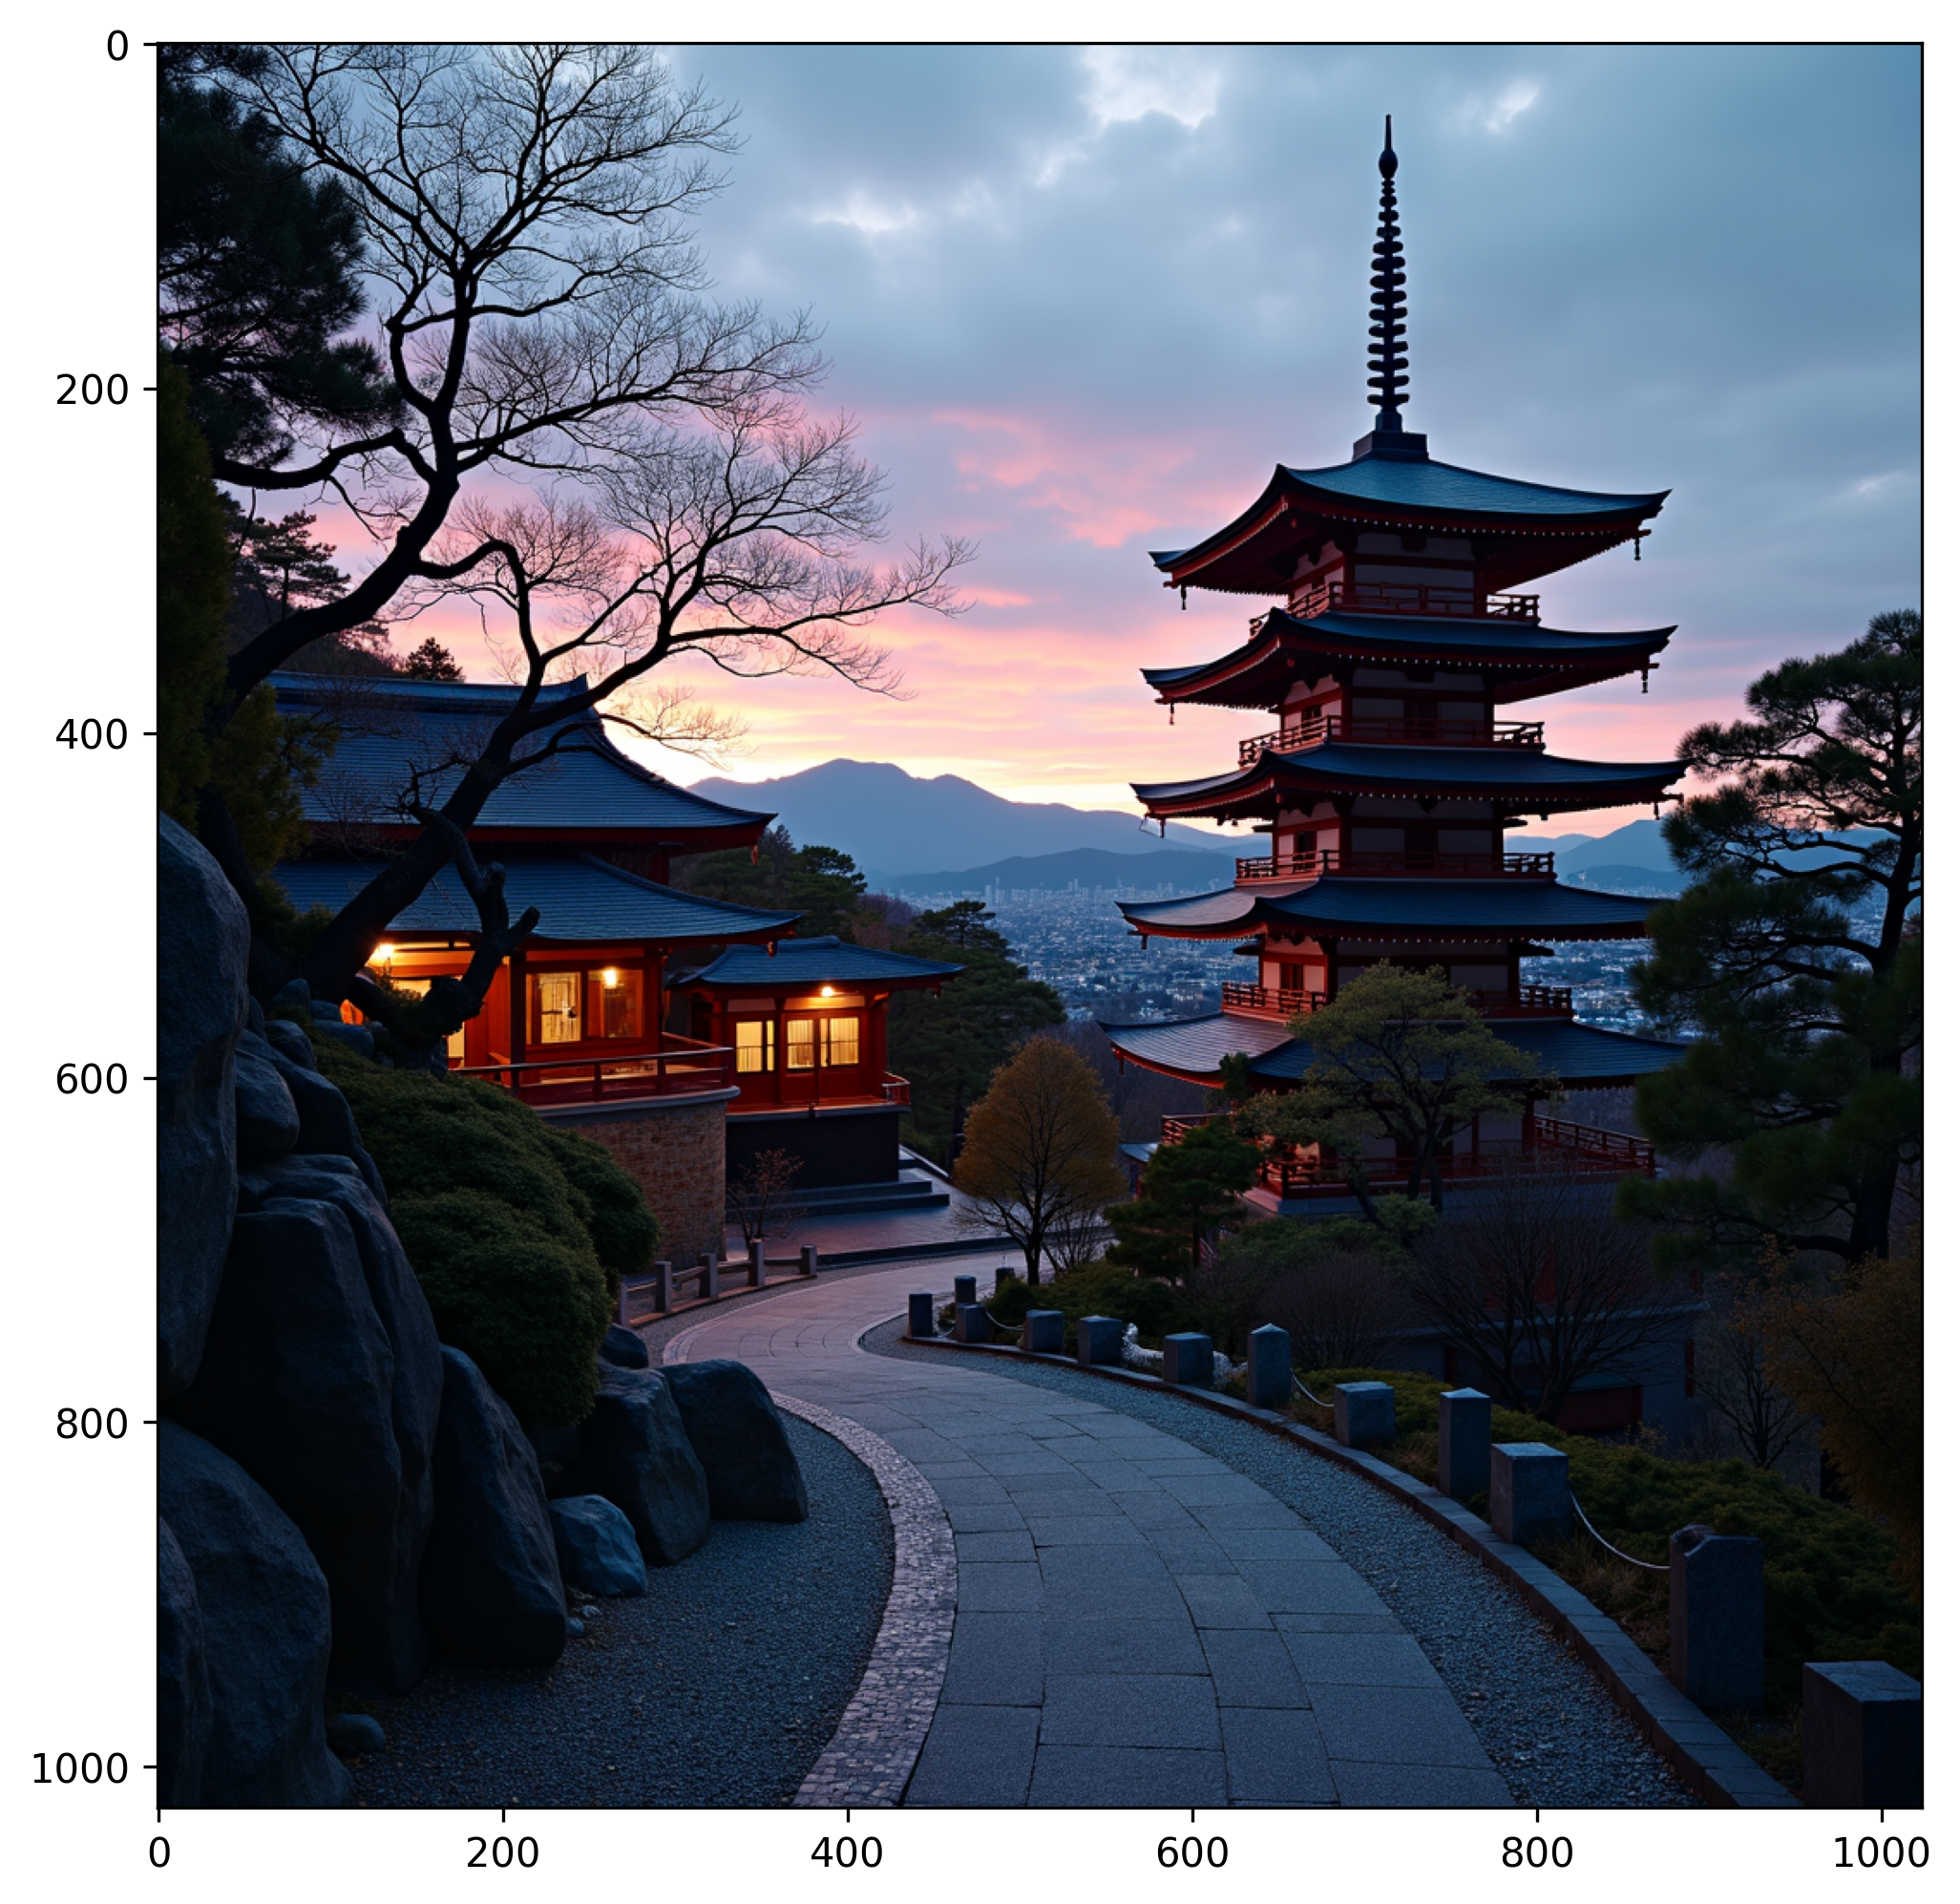

In [14]:
from matplotlib import pyplot as plt

prompt = "Photo pour Japanese pagoda and old house in Kyoto at twilight - image libre de droit"
# prompt = 'A laptop whose screen displays a picture of a black forest gateau cake spelling out the words "FLUX SCHNELL". The laptop screen, keyboard, and the table is on fire. no watermark, photograph'
# prompt = "A fancy person in LA, photorealistic, no watermark, photograph"
# prompt = "Google CTO speaking at TED talk, photorealistic, no watermark, photograph, with a background of a TED talk stage highlighting the Google logo"
out = pipe(
    prompt=prompt,
    guidance_scale=3.5,
    height=1024,
    width=1024,
    num_inference_steps=50,
	generator=torch.Generator(device='cuda').manual_seed(0)
).images[0]

plt.figure(figsize=(8, 8), dpi=300)
plt.imshow(out)

In [ ]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

In [ ]:
from transformers import T5EncoderModel
import time
import gc
import torch
import diffusers

def flush():
    gc.collect()
    torch.cuda.empty_cache()

t5_encoder = T5EncoderModel.from_pretrained(
    "black-forest-labs/FLUX.1-schnell", subfolder="text_encoder_2", torch_dtype=torch.bfloat16
)
text_encoder = diffusers.DiffusionPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-schnell",
    text_encoder_2=t5_encoder,
    transformer=None,
    vae=None,
)
pipeline = diffusers.DiffusionPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-schnell", 
    torch_dtype=torch.bfloat16,
    text_encoder_2=None,
    text_encoder=None,
)
pipeline.enable_model_cpu_offload()

In [ ]:
@torch.inference_mode()
def inference(self, prompt, num_inference_steps=4, guidance_scale=0.0, width=1024, height=1024):
    self.text_encoder.to("cuda")
    start = time.time()
    (
        prompt_embeds,
        pooled_prompt_embeds,
        _,
    ) = self.text_encoder.encode_prompt(prompt=prompt, prompt_2=None, max_sequence_length=256)
    self.text_encoder.to("cpu")
    flush()
    print(f"Prompt encoding time: {time.time() - start}")
    output = self.pipeline(
        prompt_embeds=prompt_embeds.bfloat16(),
        pooled_prompt_embeds=pooled_prompt_embeds.bfloat16(),
        width=width,
        height=height,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps
    )
    image = output.images[0]
    return image